#

In [1]:
import pulp
import networkx as nx

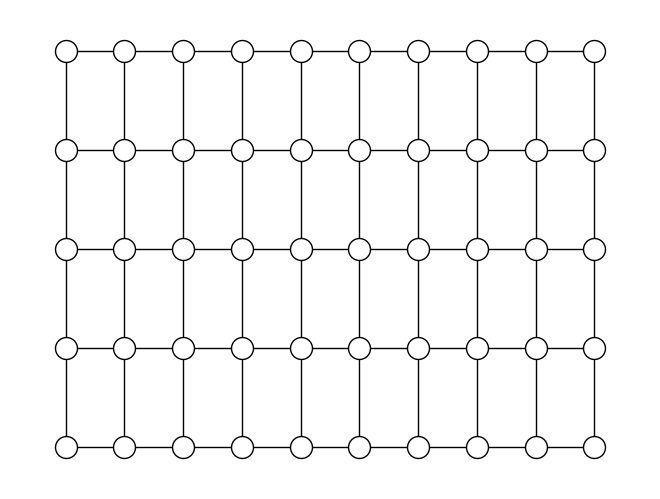

In [2]:
rows = 5
cols = 10
G = nx.grid_2d_graph(rows, cols)
for r in range(rows):
    for c in range(cols):
        G.nodes[(r, c)]["layer"] = c
nx.draw(G,pos=nx.multipartite_layout(G,subset_key="layer",align="vertical"),
        node_color="white",
        edgecolors="black",
        node_size=250)

In [3]:
ORIENTATION_NAMES = [
    "id", "rot90", "rot180", "rot270",
    "mirror", "mirror_rot90", "mirror_rot180", "mirror_rot270"
]
ORIENTATION_COLORS = {
    "id":           "#1f77b4",
    "rot90":        "#ff7f0e",
    "rot180":       "#2ca02c",
    "rot270":       "#d62728",
    "mirror":       "#9467bd",
    "mirror_rot90": "#8c564b",
    "mirror_rot180":"#e377c2",
    "mirror_rot270":"#7f7f7f",
}
Y_OFFSETS = [
    # identity
    [(0,0),(1,0),(2,0),(3,0),(2,1)],
    # rot 90
    [(0,0),(0,1),(0,2),(0,3),(1,2)],
    # rot 180
    [(0,0),(-1,0),(-2,0),(-3,0),(-2,-1)],
    # rot 270
    [(0,0),(0,-1),(0,-2),(0,-3),(-1,-2)],
    # mirror y-axis
    [(0,0),(-1,0),(-2,0),(-3,0),(-2,1)],
    # mirror + rot 90
    [(0,0),(0,-1),(0,-2),(0,-3),(1,-2)],
    # mirror + rot 180
    [(0,0),(1,0),(2,0),(3,0),(2,-1)],
    # mirror + rot 270
    [(0,0),(0,1),(0,2),(0,3),(-1,2)],
]

pentominoes = []
for node in G.nodes():
    x0, y0 = node
    #for ori in Y_OFFSETS:
    for ori_offsets, ori_name in zip(Y_OFFSETS, ORIENTATION_NAMES):
        Y = [(x0 + dx, y0 + dy) for (dx, dy) in ori_offsets]
        if all(G.has_node(v) for v in Y): 
            P=G.subgraph(Y).copy()
            P.graph["orientation"] = ori_name       
            P.graph["color"] = ORIENTATION_COLORS[ori_name]  
            pentominoes.append(P)
pentominoes_dict = dict(zip([i for i in range(len(pentominoes))],pentominoes))

In [4]:
# create problem
prob = pulp.LpProblem("pentomino", pulp.LpMinimize)

# x[p] = 1 pentamino p is used
x = pulp.LpVariable.dicts("x",pentominoes_dict,cat=pulp.LpBinary)

# dummy objective
prob+= 0

# each node shold be covered exactly once
for (r,c) in G.nodes():
    prob+= pulp.lpSum(x[p] for p in pentominoes_dict if (r,c) in pentominoes_dict[p].nodes()) == 1

In [5]:
prob.solve()

1

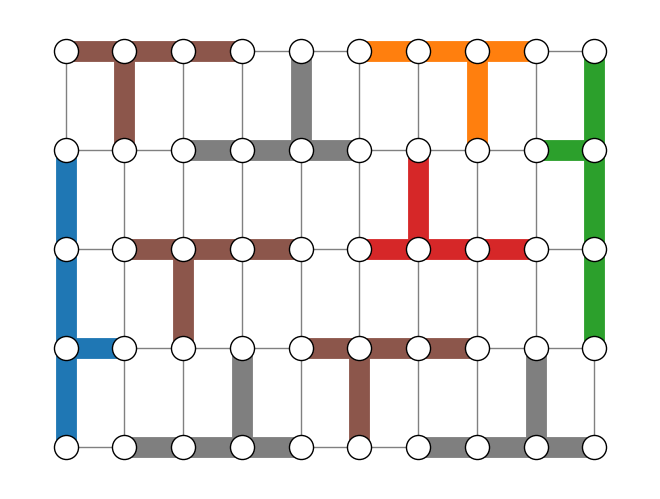

In [6]:
pos = {(x, y): (y, -x) for x, y in G.nodes()} 
nx.draw(G, pos, node_size=10, edge_color='grey')
for p in x:
    if pulp.value(x[p])>0.9:
        P = pentominoes_dict[p]
        nx.draw(P, pos, 
                node_color="white",
                edgecolors="black",
                edge_color=P.graph["color"],
                width=15)